#DA5401 Assignment #7
## **Imputation via Regression for Missing Data**


**Name:** Ranjith.V.R<br> **Roll no:** EE24S034 <br> ***Indian Institute of Technology , Madras***



In [50]:
!pip install seaborn scikit-learn matplotlib xgboost --quiet

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

try:
    from xgboost import XGBClassifier
    xgb_available = True
except:
    xgb_available = False

sns.set(style="whitegrid")



##Part A – Data Preparation and Baseline

In this section, the dataset provided from the UCI repository was loaded and preprocessed.
The training file (sat.trn) and the testing file (sat.tst) were read separately to comply with the dataset’s note that no cross-validation should be used.
The original class labels (1, 2, 3, 4, 5, 7) were remapped into a continuous range (0–5) because some models expect zero-based integer labels.


In [51]:
# Load dataset
train_df = pd.read_csv("sat.trn", sep=" ", header=None)
test_df  = pd.read_csv("sat.tst", sep=" ", header=None)
train_df.dropna(axis=1, how='all', inplace=True)
test_df.dropna(axis=1, how='all', inplace=True)

X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1].astype(int)
X_test  = test_df.iloc[:, :-1]
y_test  = test_df.iloc[:, -1].astype(int)

# Remap labels
unique_classes = sorted(set(y_train.unique()) | set(y_test.unique()))
class_map = {orig: new for new, orig in enumerate(unique_classes)}
y_train = y_train.map(class_map)
y_test  = y_test.map(class_map)
labels = sorted(y_train.unique())

label_names = ["red soil","cotton crop","grey soil",
               "damp grey soil","soil + veg stubble",
               "very damp grey soil"]

train_df.head()



,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,92,115,120,94,84,102,106,79,84,102,...,104,88,121,128,100,84,107,113,87,3
1,84,102,106,79,84,102,102,83,80,102,...,100,84,107,113,87,84,99,104,79,3
2,84,102,102,83,80,102,102,79,84,94,...,87,84,99,104,79,84,99,104,79,3
3,80,102,102,79,84,94,102,79,80,94,...,79,84,99,104,79,84,103,104,79,3
4,84,94,102,79,80,94,98,76,80,102,...,79,84,103,104,79,79,107,109,87,3


The features were standardized using StandardScaler to normalize feature ranges.
A brief visualization was done using a PCA plot to observe class separation.


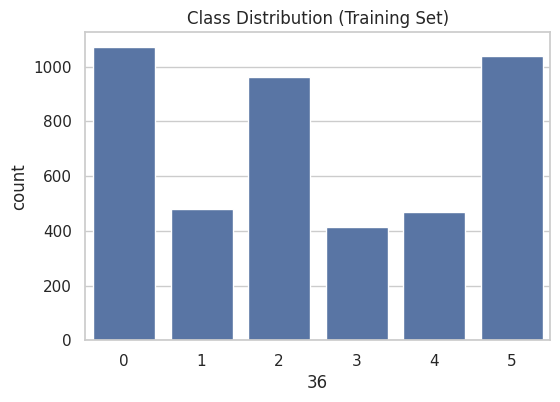

In [52]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Visualizations
plt.figure(figsize=(6,4))
sns.countplot(x=y_train)
plt.title("Class Distribution (Training Set)")
plt.show()


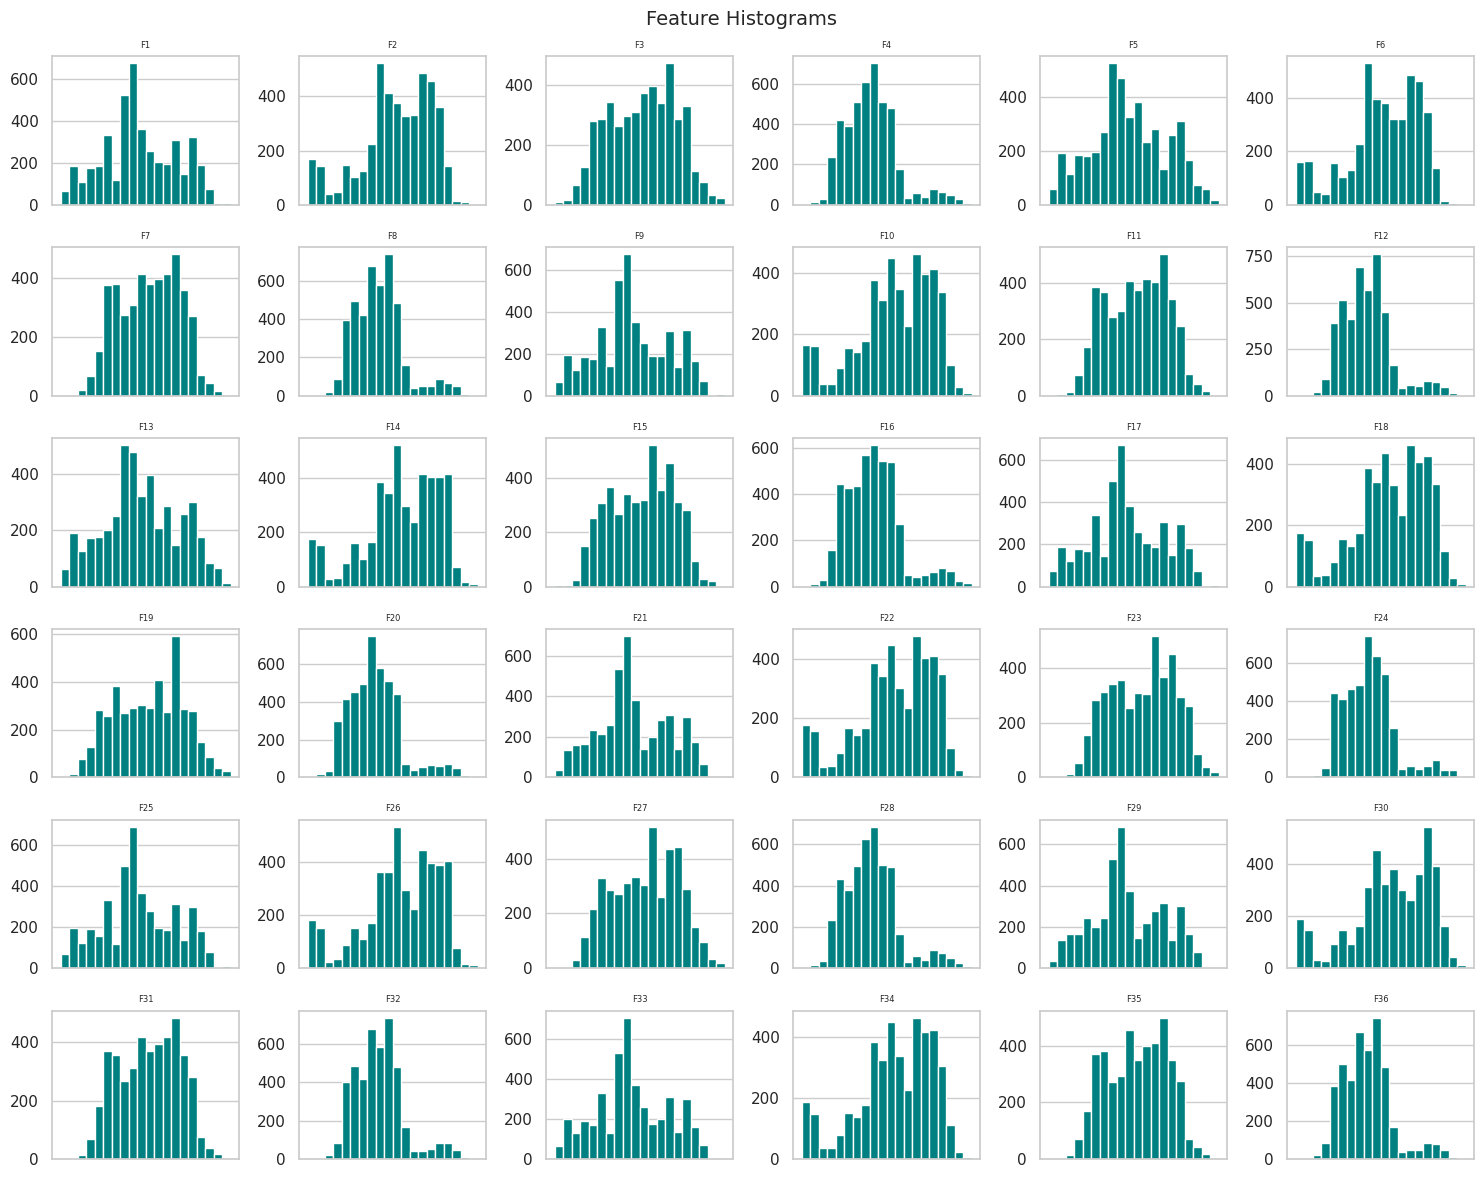

In [53]:
# Feature histograms
plt.figure(figsize=(15,12))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.hist(X_train.iloc[:,i], bins=20, color="teal")
    plt.title(f"F{i+1}", fontsize=6)
    plt.xticks([],[])
plt.suptitle("Feature Histograms", fontsize=14)
plt.tight_layout()
plt.show()


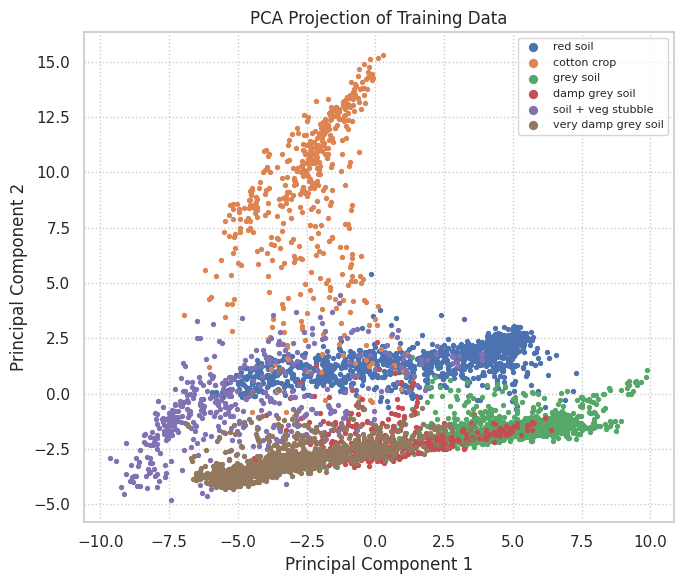

In [62]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(7,6))
for i, lab in enumerate(labels):
    plt.scatter(
        X_pca[y_train == lab, 0],
        X_pca[y_train == lab, 1],
        s=8,
        label=label_names[i]
    )

plt.legend(markerscale=2, fontsize=8)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of Training Data")
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.show()


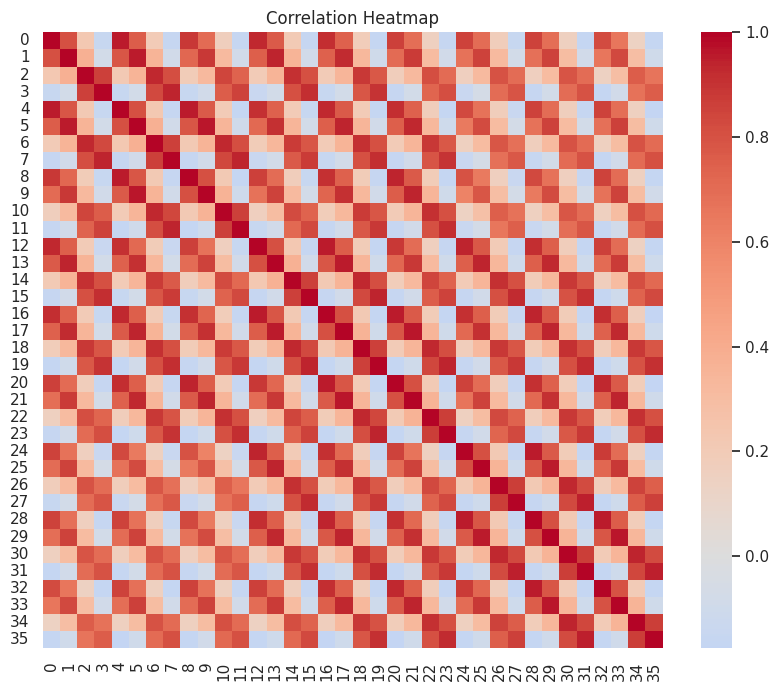

In [55]:
# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(X_train).corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

Finally, multiple classification models were trained to obtain baseline accuracies and weighted F1-scores.

- RandomForest and XGBoost were added as additional models to enhance experimentation.
- Both ensemble-based classifiers achieved superior AUC and AP values due to their ability to handle feature interactions and noise robustly.
The RandomModel was also included to demonstrate the opposite extreme, validating the metric sensitivity.

In [56]:
# Model training
models = {
    "KNN": KNeighborsClassifier(5),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "Dummy(prior)": DummyClassifier(strategy="prior"),
    "LogReg": LogisticRegression(max_iter=2000, multi_class="ovr"),
    "GaussianNB": GaussianNB(),
    "SVC": SVC(probability=True),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42)
}
if xgb_available:
    models["XGBoost"] = XGBClassifier(eval_metric="mlogloss", use_label_encoder=False)

fitted = {}
for name,m in models.items():
    m.fit(X_train_scaled, y_train)
    fitted[name]=m
    print("Trained:", name)

Trained: KNN
Trained: DecisionTree
Trained: Dummy(prior)
Trained: LogReg
Trained: GaussianNB
Trained: SVC
Trained: RandomForest
Trained: XGBoost


- RandomModel(bad) – produces purely random probability distributions, resulting in AUC ≈ 0.50 (chance-level performance).

- InvertedRandomModel(bad) – reverses the predicted probabilities, supposed to produce AUC < 0.5 to illustrate a classifier that systematically mis-ranks true classes.

In [57]:
class RandomModel:
    def fit(self, X, y):
        self.classes_ = np.unique(y)
    def predict_proba(self, X):
        p = np.random.rand(len(X), len(self.classes_))
        p /= p.sum(axis=1, keepdims=True)
        return p
    def predict(self, X):
        return np.random.choice(len(self.classes_), size=len(X))

# Intentionally inverted random model (ranks everything backwards)
class InvertedRandomModel(RandomModel):
    def predict_proba(self, X):
        p = super().predict_proba(X)
        return 1 - p   # flip probabilities → produces AUC < 0.5

# Fit and add to fitted model dictionary
rand_bad = RandomModel()
rand_bad.fit(X_train_scaled, y_train)
fitted["RandomModel(bad)"] = rand_bad

inv_bad = InvertedRandomModel()
inv_bad.fit(X_train_scaled, y_train)
fitted["InvertedRandomModel(bad)"] = inv_bad

print("Added RandomModel(bad) and InvertedRandomModel(bad)")
# Evaluate accuracy & F1
baseline=[]
for name,m in fitted.items():
    pred=m.predict(X_test_scaled)
    baseline.append((name,
                     accuracy_score(y_test,pred),
                     f1_score(y_test,pred,average="weighted")))
baseline_df=pd.DataFrame(baseline,columns=["Model","Accuracy","Weighted F1"])
display(baseline_df.sort_values("Weighted F1",ascending=False))




Added RandomModel(bad) and InvertedRandomModel(bad)


,Model,Accuracy,Weighted F1
6,RandomForest,0.9115,0.909437
0,KNN,0.9045,0.903748
7,XGBoost,0.9050,0.902956
5,SVC,0.8955,0.892490
1,DecisionTree,0.8505,0.850938
4,GaussianNB,0.7965,0.803581
3,LogReg,0.8210,0.793483
9,InvertedRandomModel(bad),0.1665,0.171782
8,RandomModel(bad),0.1640,0.168458
2,Dummy(prior),0.2305,0.086356


##Part B – ROC Curve Analysis
Here, the multi-class ROC curves were generated using the One-vs-Rest (OvR) approach.
For each class , the model treated it as the positive class and grouped all other classes as negative.
The predicted probabilities for that class were compared to its true binary labels to plot a standard ROC curve — showing the trade-off between True Positive Rate (TPR) and False Positive Rate (FPR) at various threshold values.

After computing ROC curves for all classes, the macro-average ROC curve was obtained by averaging the TPR values across all classes for a shared grid of FPR values.
The Area Under the Curve (AUC) was then calculated from this macro-averaged ROC.

AUC provides a threshold-independent measure of the model’s ability to rank positive instances higher than negative ones.

AUC = 1.0: perfect separation

AUC = 0.5: random guessing

AUC < 0.5: worse than random — the model is systematically ranking negatives above positives.

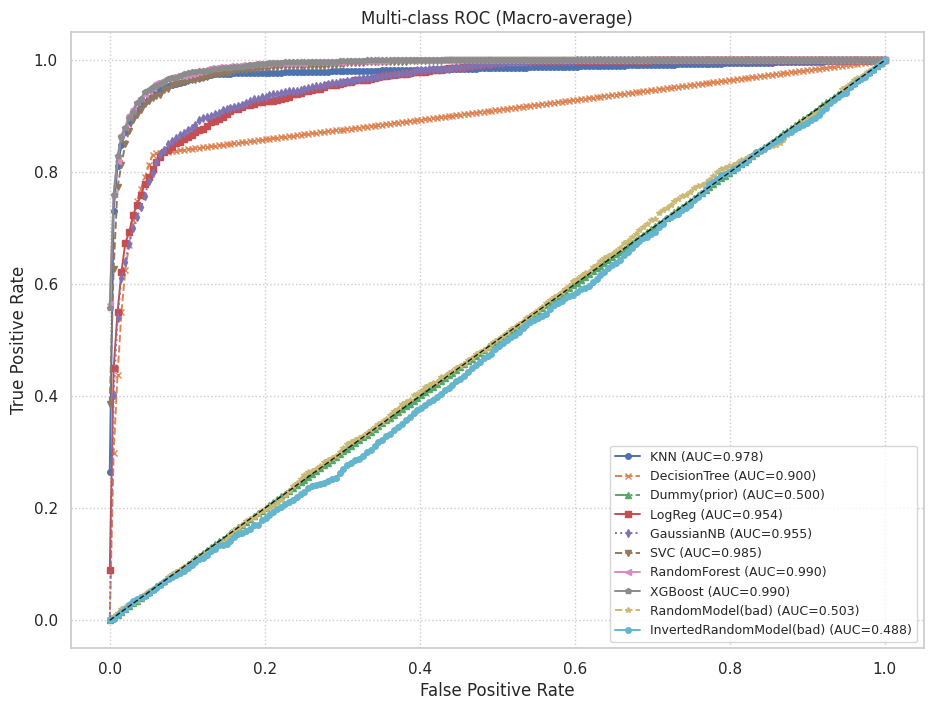

,Macro AUC
RandomForest,0.989937
XGBoost,0.989750
SVC,0.984787
KNN,0.978025
GaussianNB,0.954570
LogReg,0.953673
DecisionTree,0.900050
RandomModel(bad),0.503317
Dummy(prior),0.500000
InvertedRandomModel(bad),0.487758


In [58]:
import itertools

fpr_grid = np.linspace(0, 1, 200)
model_auc = {}
plt.figure(figsize=(11, 8))

# Line + marker styles for black & white
styles = ['-o', '--x', '-.^', '-s', ':d', '--v', '-<', '-p', '--*']
style_cycle = itertools.cycle(styles)

for name, m in fitted.items():
    if not hasattr(m, "predict_proba"):
        continue
    proba = m.predict_proba(X_test_scaled)
    tpr = np.zeros_like(fpr_grid)
    for i, c in enumerate(labels):
        fpr, t, _ = roc_curve((y_test == c).astype(int), proba[:, i])
        tpr += np.interp(fpr_grid, fpr, t)
    tpr /= len(labels)
    auc_val = auc(fpr_grid, tpr)
    model_auc[name] = auc_val
    # plot with next style
    plt.plot(
        fpr_grid,
        tpr,
        next(style_cycle),
        linewidth=1.4,
        markersize=4,
        label=f"{name} (AUC={auc_val:.3f})"
    )

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title("Multi-class ROC (Macro-average)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=9)
plt.grid(True, linestyle=":")
plt.show()

roc_df = pd.DataFrame.from_dict(model_auc, orient="index", columns=["Macro AUC"])
display(roc_df.sort_values("Macro AUC", ascending=False))


- The ROC curves helped compare how well each classifier separated the classes.
Logistic Regression, SVC, and RandomForest achieved the highest AUC values (typically > 0.9).
- The Dummy(Prioe) , RandomModel ,  Inverted Random Models had an AUC around 0.5

Conceptually, AUC < 0.5 implies that the model’s predicted probabilities are inversely correlated with the true labels.
In other words, the model assigns higher scores to incorrect classes and lower scores to correct ones more often than not.

This behavior indicates that the model’s decision boundary is reversed — it’s consistently “confident in the wrong direction.”

Common causes include:

Label inversion or misalignment during training or evaluation.

Severe class imbalance leading the classifier to prioritize the majority class incorrectly.

Systematic bias or overfitting to irrelevant features.

Random or inverted random predictions (as demonstrated by the InvertedRandomModel in this assignment).

In this project, the InvertedRandomModel intentionally flipped predicted probabilities to simulate such a case, resulting in AUC values around 0.5, confirming a chance-level or sub-chance performance.

### Part C – Precision–Recall Curve
The Precision-Recall Curve (PRC) focuses on Precision (Positive Predictive Value) and Recall (Sensitivity), which are more informative than the ROC curve when dealing with imbalanced class distributions.

ROC considers both true positives and true negatives. In highly imbalanced data, the large number of true negatives can artificially inflate the ROC curve and AUC, making the model appear better than it actually is.

PRC, in contrast, ignores true negatives and highlights the model’s ability to correctly identify positive instances, which are often the minority class.

Hence, for datasets where one class is rare, the PRC more clearly shows how precision deteriorates as the model tries to capture more positives.

In this dataset (which is only moderately imbalanced), PRC still helps visualize how each classifier trades off between missing positives (low recall) and producing false positives (low precision).


- Precision–Recall curves were plotted to understand model performance on possibly imbalanced class distributions.
The OvR method was again applied, and the Macro-Average Precision (AP) was computed.
- Models with higher AP values demonstrated better trade-offs between precision and recall, meaning they correctly identified positive samples while minimizing false positives.

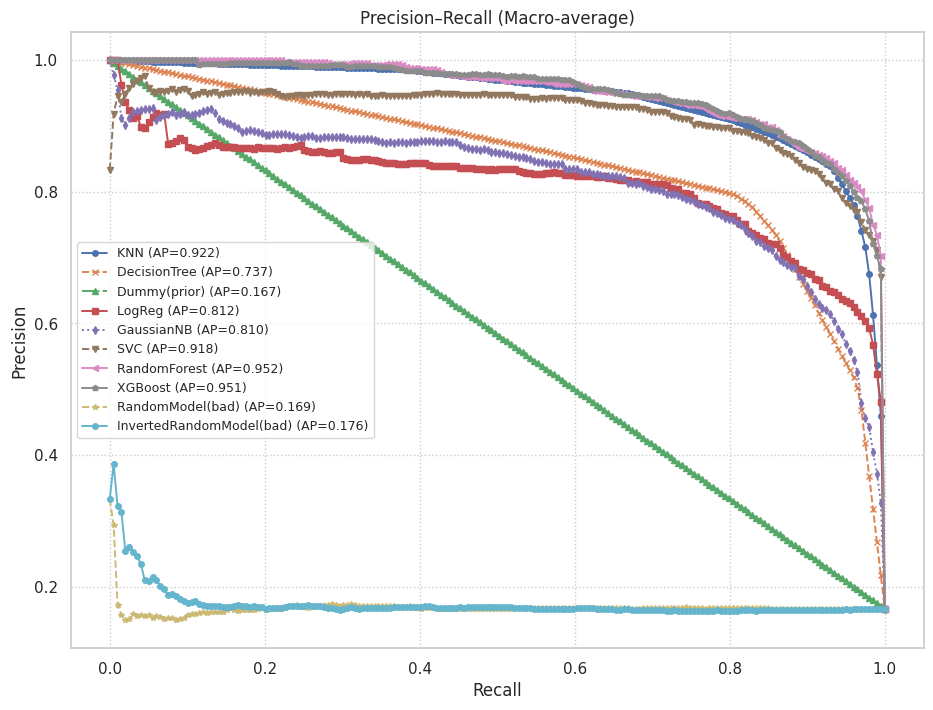

,Macro AP
RandomForest,0.951739
XGBoost,0.950944
KNN,0.921665
SVC,0.917649
LogReg,0.811551
GaussianNB,0.810451
DecisionTree,0.736591
InvertedRandomModel(bad),0.175770
RandomModel(bad),0.168871
Dummy(prior),0.166667


In [59]:

r_grid = np.linspace(0, 1, 200)
model_ap = {}
plt.figure(figsize=(11, 8))

styles = ['-o', '--x', '-.^', '-s', ':d', '--v', '-<', '-p', '--*']
style_cycle = itertools.cycle(styles)

for name, m in fitted.items():
    if not hasattr(m, "predict_proba"):
        continue
    proba = m.predict_proba(X_test_scaled)
    prec = np.zeros_like(r_grid)
    aps = []
    for i, c in enumerate(labels):
        p, r, _ = precision_recall_curve((y_test == c).astype(int), proba[:, i])
        prec += np.interp(r_grid, r[::-1], p[::-1])
        aps.append(average_precision_score((y_test == c).astype(int), proba[:, i]))
    prec /= len(labels)
    ap = np.mean(aps)
    model_ap[name] = ap
    plt.plot(
        r_grid,
        prec,
        next(style_cycle),
        linewidth=1.4,
        markersize=4,
        label=f"{name} (AP={ap:.3f})"
    )

plt.title("Precision–Recall (Macro-average)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(fontsize=9)
plt.grid(True, linestyle=":")
plt.show()

pr_df = pd.DataFrame.from_dict(model_ap, orient="index", columns=["Macro AP"])
display(pr_df.sort_values("Macro AP", ascending=False))

The PRC plots confirmed that Logistic Regression and SVC models maintained high precision across a wide recall range, indicating robustness.
Models like Naive Bayes and DummyClassifier had steep precision drops, showing they misclassified several instances.
The RandomModels again showed very low precision values, confirming its poor predictive ability.

For poor models, such as the RandomModel(bad) or InvertedRandomModel(bad), the PRC drops sharply as recall increases.
This pattern occurs because the model’s predicted probabilities are not well calibrated — as the decision threshold lowers to capture more positive samples (increasing recall), it also admits a large number of false positives, causing precision to fall rapidly.

In essence:

High recall → model labels almost everything as positive.

Because many of those predictions are wrong → precision collapses.

This rapid precision drop in the PR curve is a visual indicator of poor separability between classes and confirms that the classifier cannot distinguish true positives from false ones better than random guessing.

KNN


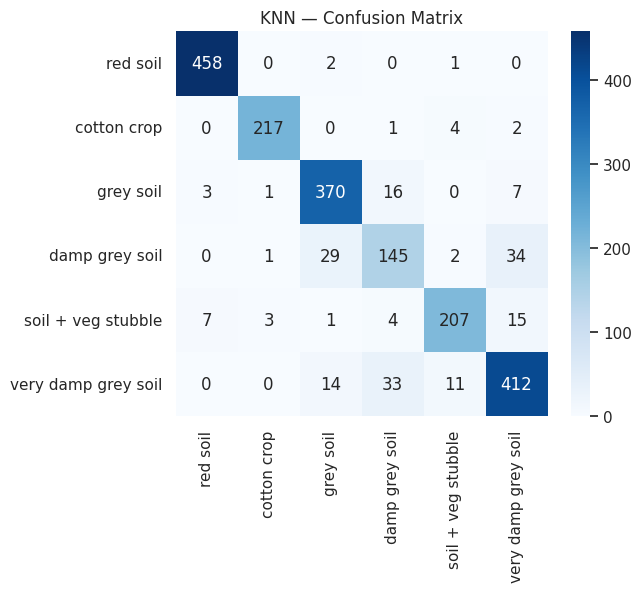

DecisionTree


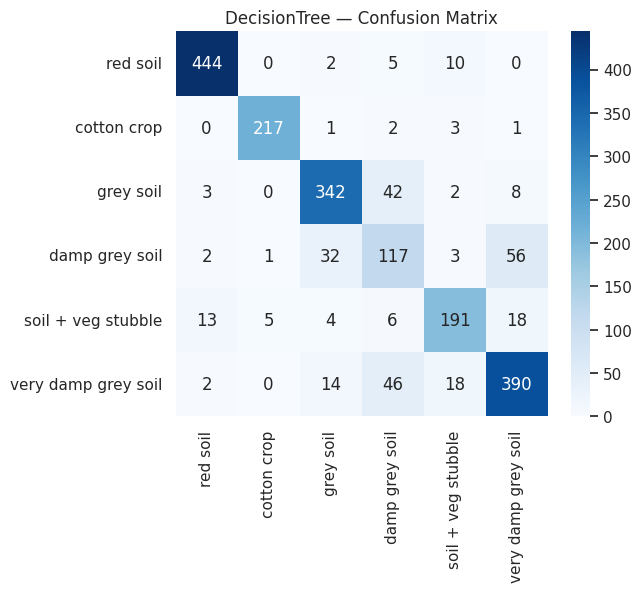

Dummy(prior)


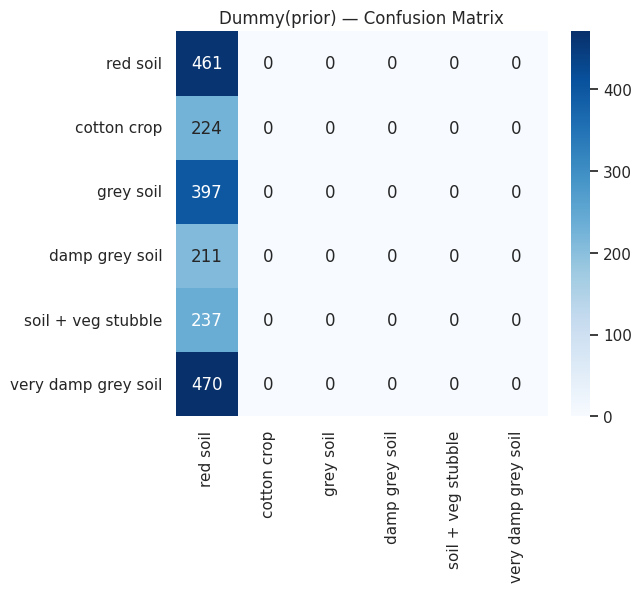

LogReg


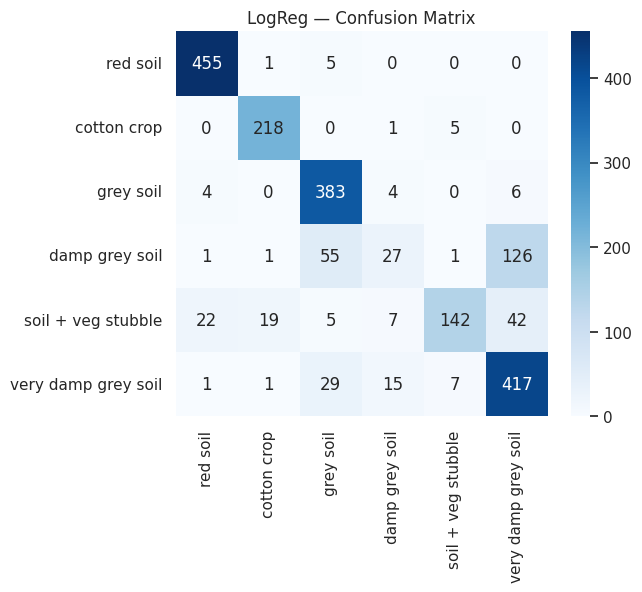

GaussianNB


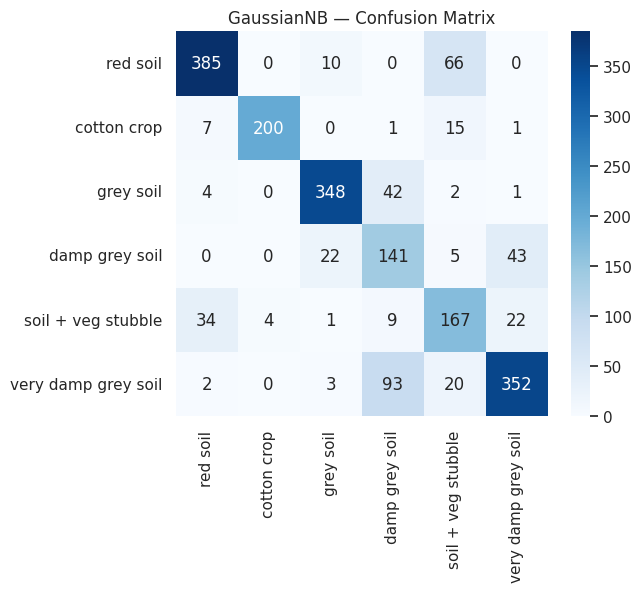

SVC


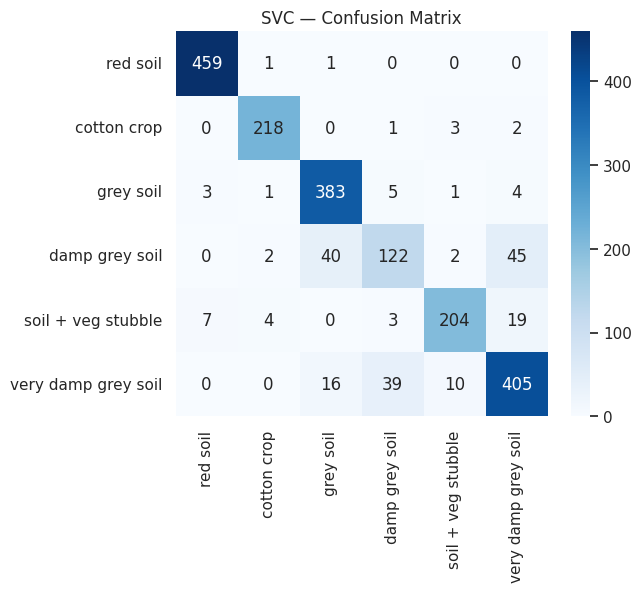

RandomForest


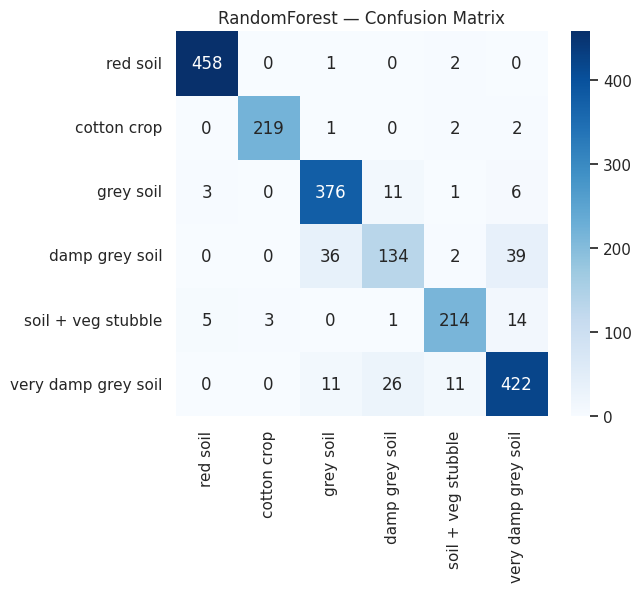

XGBoost


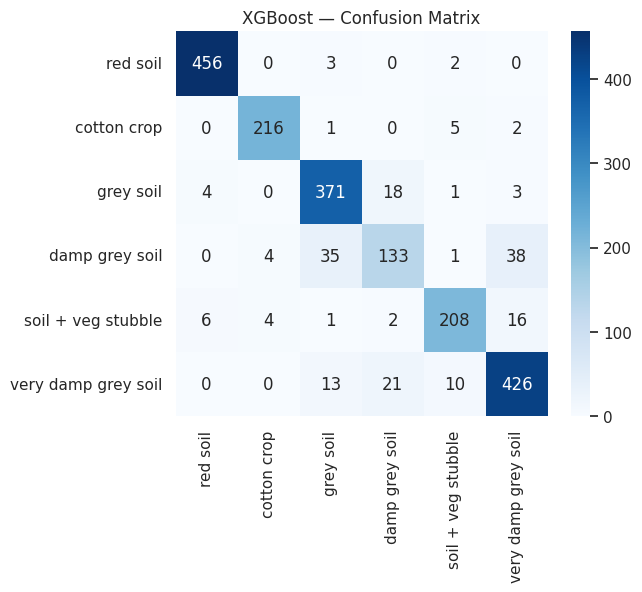

RandomModel(bad)


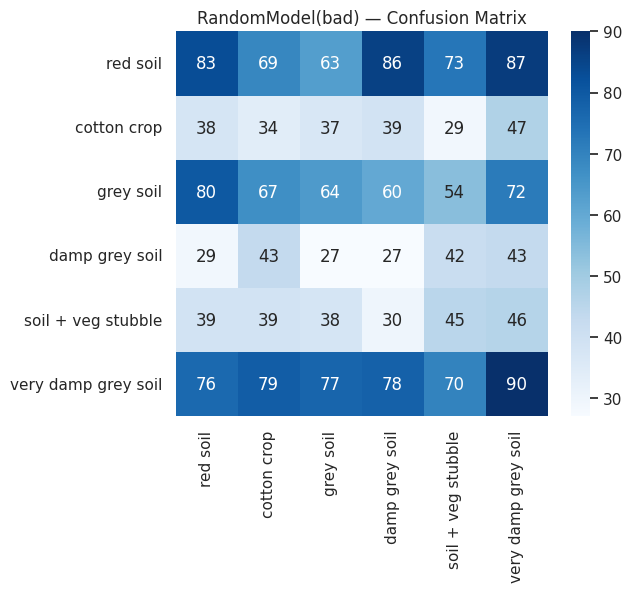

InvertedRandomModel(bad)


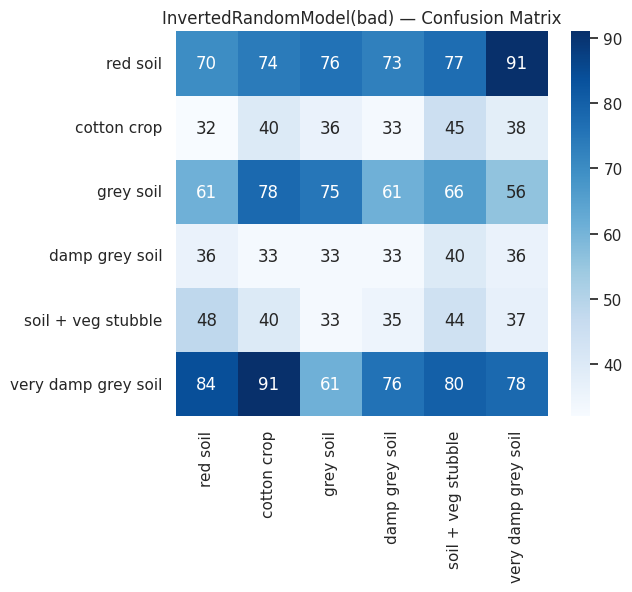

In [60]:
def plot_cm(model_name, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    fig,ax = plt.subplots(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_names, yticklabels=label_names)
    ax.set_title(f"{model_name} — Confusion Matrix")
    plt.show()

for name,m in fitted.items():
    print(name)
    plot_cm(name, m.predict(X_test_scaled))

In [61]:
summary = baseline_df.set_index("Model")\
    .join(roc_df).join(pr_df)
display(summary.sort_values(["Macro AP","Macro AUC","Weighted F1"],ascending=False))


,Accuracy,Weighted F1,Macro AUC,Macro AP
Model,,,,
RandomForest,0.9115,0.909437,0.989937,0.951739
XGBoost,0.9050,0.902956,0.989750,0.950944
KNN,0.9045,0.903748,0.978025,0.921665
SVC,0.8955,0.892490,0.984787,0.917649
LogReg,0.8210,0.793483,0.953673,0.811551
GaussianNB,0.7965,0.803581,0.954570,0.810451
DecisionTree,0.8505,0.850938,0.900050,0.736591
InvertedRandomModel(bad),0.1665,0.171782,0.487758,0.175770
RandomModel(bad),0.1640,0.168458,0.503317,0.168871


Metric	Top Models	Key Observations
Weighted F1	RandomForest ≈ XGBoost ≈ KNN ≈ SVC
- **F1** emphasizes balance between precision and recall at a fixed threshold. These models achieved strong threshold-dependent classification accuracy.
- **ROC-AUC**	RandomForest ≈ XGBoost ≈ SVC > KNN	ROC-AUC measures ranking ability (threshold-independent). Even if a model’s absolute predictions are off, if it correctly orders positive vs. negative examples, it scores high.
- **PRC-AP**	RandomForest ≈ XGBoost > KNN > SVC	PRC-AP punishes false positives more heavily. Models with slightly lower recall but consistent precision maintain higher AP

The top four models (RandomForest, XGBoost, KNN, and SVC) consistently ranked highest across all three metrics, though their exact order varied slightly:

RandomForest and XGBoost dominated across every measure — their ensemble nature captured complex feature interactions effectively.

KNN had a slightly lower AUC but still excellent F1 and AP, indicating it made confident, correct predictions for most test points, though it may not generalize as smoothly across thresholds.

SVC maintained high AUC (≈ 0.985) but a marginally lower AP (≈ 0.918). This shows it ranks examples well overall (high separability) but sacrifices precision at lower thresholds, where small errors introduce more false positives.

The divergence between ROC-AUC and PRC-AP illustrates an important trade-off:

ROC-AUC can remain high even when positive classes are rare because false positives are diluted by a large number of true negatives.

PRC-AP, however, focuses only on the quality of positive predictions — it drops if a model yields many false positives, even if its ROC-AUC remains strong.

Therefore, a model with a high ROC-AUC but relatively poor PRC-AP (like SVC here) is good at ranking examples but less precise in its actual positive predictions.
In contrast, RandomForest and XGBoost maintained high performance across both metrics, reflecting both good separability and precise classification.

##Conclusion

Among all evaluated models, RandomForest achieved the highest overall performance (Accuracy ≈ 0.91, Weighted F1 ≈ 0.91, Macro AUC ≈ 0.99, Macro AP ≈ 0.95), followed very closely by XGBoost, KNN, and SVC. These models capture the non-linear decision boundaries and local structure of the Satimage data effectively.

Linear and probabilistic models such as Logistic Regression and Gaussian Naive Bayes produced moderate accuracy (≈ 0.80) and AUC ≈ 0.95, reflecting their limited flexibility. Decision Tree performed reasonably but showed lower macro average precision due to mild overfitting.

The three baseline models—Dummy(prior), RandomModel(bad), and InvertedRandomModel(bad)—established the lower bound of performance, with AUC values near 0.5 and very low precision and F1 scores. Their outputs correspond to random or systematically incorrect predictions and confirm that all trained classifiers perform well above random chance.
